{'train': ((3280, 192, 240), (3280, 192, 240)), 'test': ((3034, 192, 240), (3034, 192, 240)), 'val': ((820, 192, 240), (820, 192, 240))}
===== TRAIN =====
TRAIN -> Bild 0


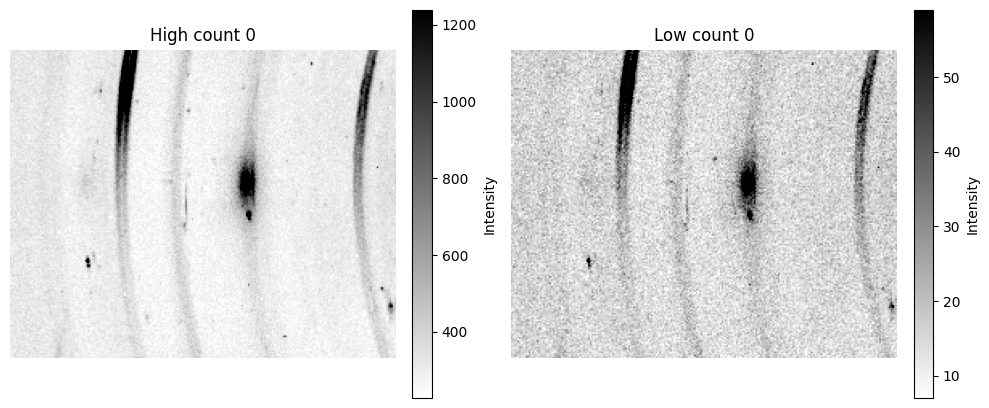

===== TEST =====
TEST -> Bild 0


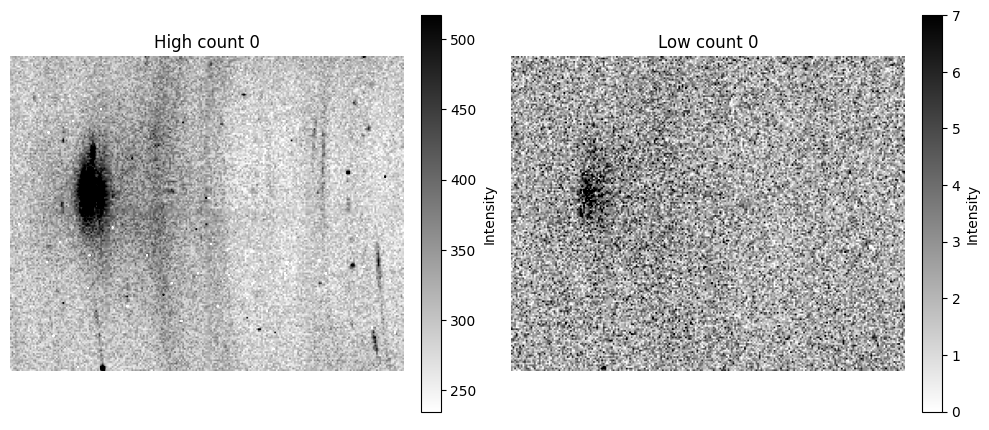

===== VAL =====
VAL -> Bild 0


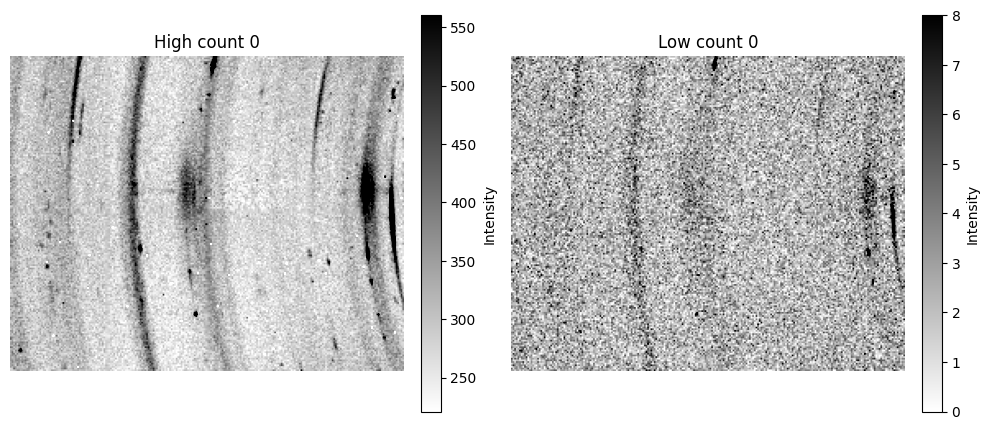

In [7]:
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

def show_pair(high_img, low_img, idx, p_low=1, p_high=99, share_scale=False):
    def robust_minmax(img):
        vals = img.ravel()
        vmin, vmax = np.percentile(vals, (p_low, p_high))
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
            vmin, vmax = float(vals.min()), float(vals.max() + 1e-6)
        return vmin, vmax

    if share_scale:
        vmin_h, vmax_h = robust_minmax(high_img)
        vmin_l, vmax_l = robust_minmax(low_img)
        vmin = min(vmin_h, vmin_l); vmax = max(vmax_h, vmax_l)
        vmin_h = vmin_l = vmin; vmax_h = vmax_l = vmax
    else:
        vmin_h, vmax_h = robust_minmax(high_img)
        vmin_l, vmax_l = robust_minmax(low_img)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    im0 = axes[0].imshow(high_img, cmap="gray_r", origin="lower", aspect="equal",
                         vmin=vmin_h, vmax=vmax_h)
    axes[0].set_title(f"High count {idx}"); axes[0].axis("off")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04).set_label("Intensity")

    im1 = axes[1].imshow(low_img, cmap="gray_r", origin="lower", aspect="equal",
                         vmin=vmin_l, vmax=vmax_l)
    axes[1].set_title(f"Low count {idx}"); axes[1].axis("off")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04).set_label("Intensity")

    plt.tight_layout(); plt.show()

# Ordner mit den HDF5-Dateien
DATA_DIR = Path(r"C:\Users\sandr\VS_Master_Thesis\data\original_data")

def load_all(path: Path):
    with h5py.File(path, "r") as f:
        high = f["/high_count/data"][:]      # (H,W,N)
        low  = f["/low_count/data"][:]       # (H,W,N)
    return high.transpose(2,0,1), low.transpose(2,0,1)  # -> (N,H,W)

paths = {
    "train": DATA_DIR / "training_data.hdf5",
    "test":  DATA_DIR / "test_data.hdf5",
    "val":   DATA_DIR / "validation_data.hdf5",
}

data = {name: load_all(p) for name, p in paths.items()}

print({name: (h.shape, l.shape) for name,(h,l) in data.items()})

indices = [0]
for split in ["train", "test", "val"]:
    high, low = data[split]
    print(f"===== {split.upper()} =====")
    for idx in indices:
        print(f"{split.upper()} -> Bild {idx}")
        show_pair(high[idx], low[idx], idx)   # ensure show_pair ist definiert

===== TRAIN =====


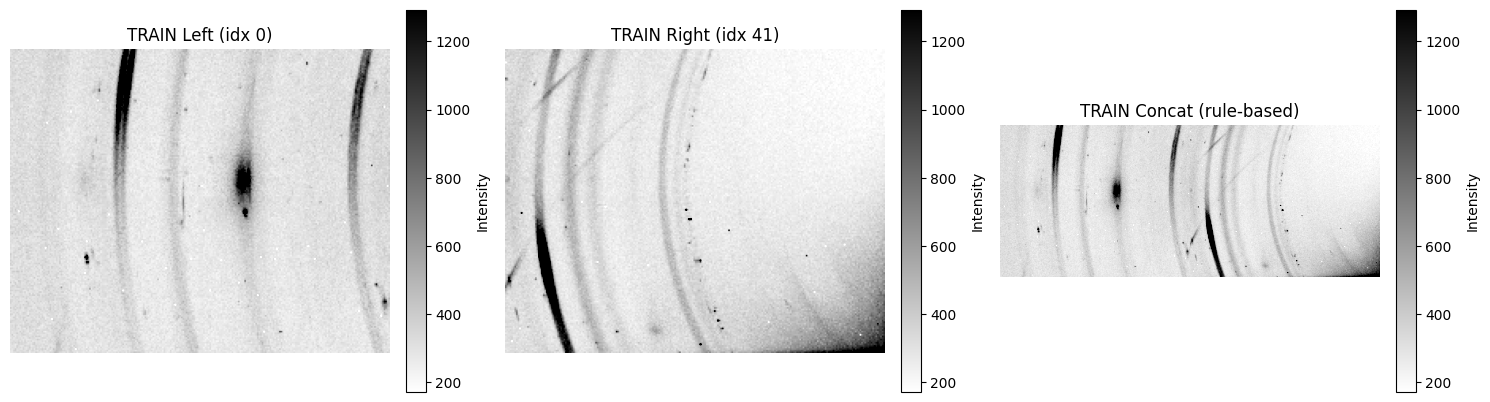

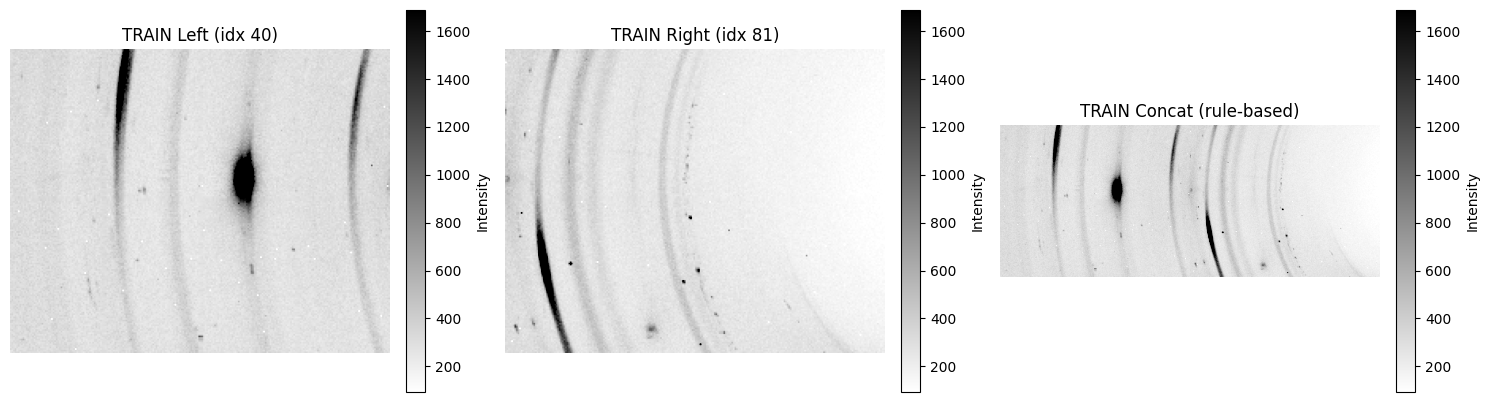

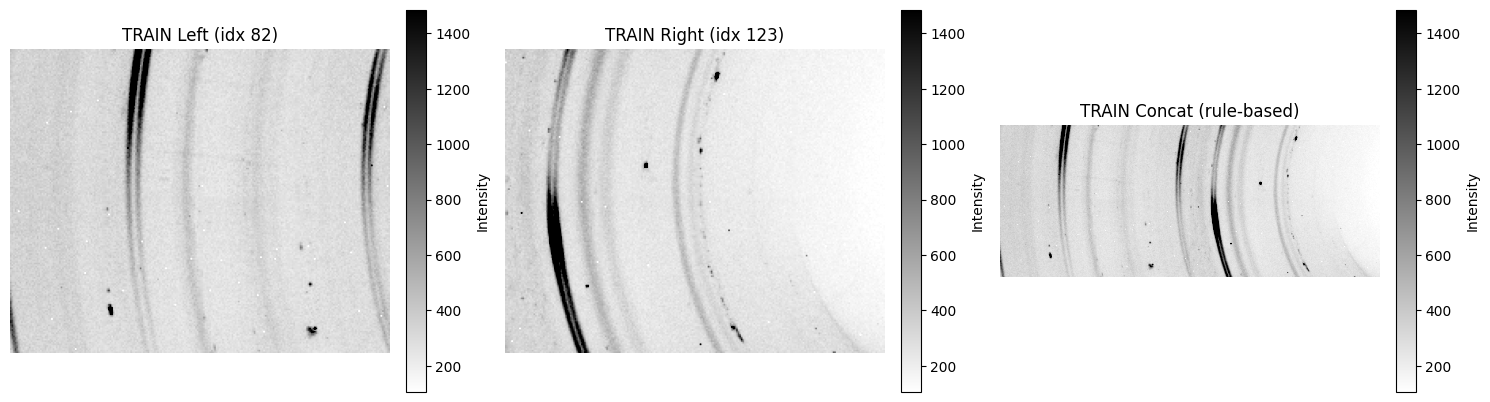

===== TEST =====


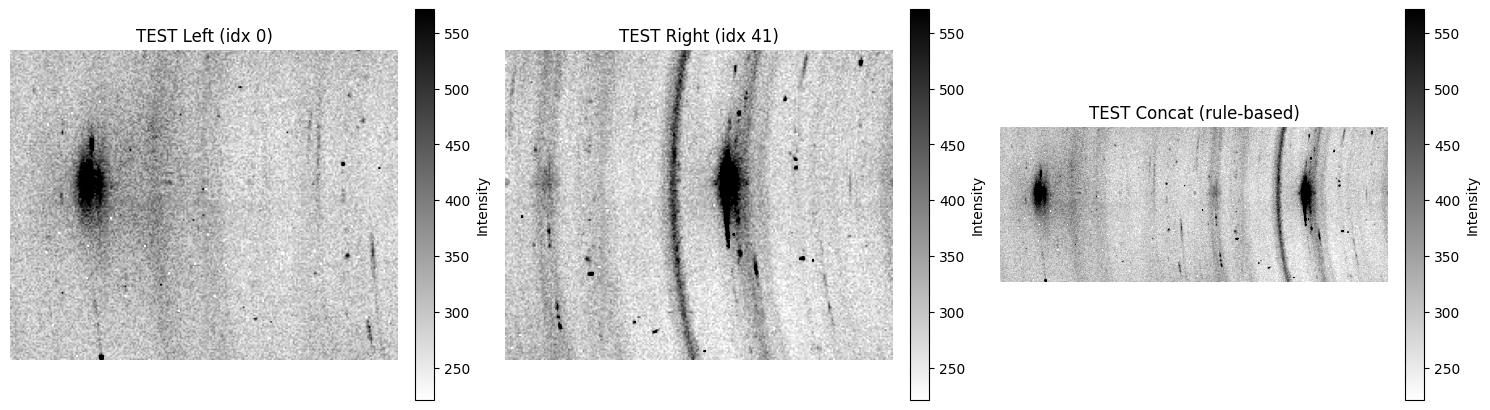

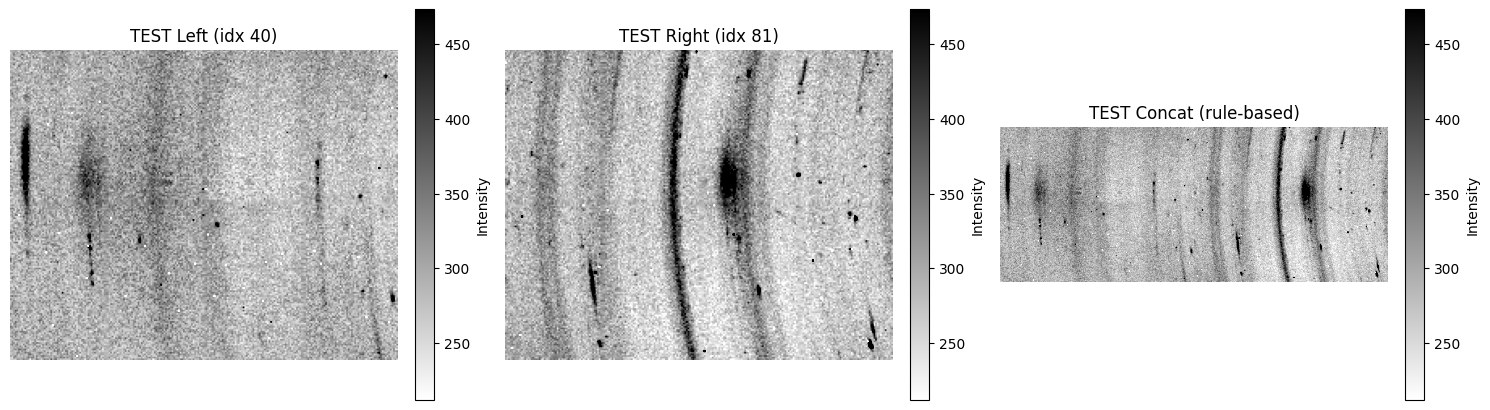

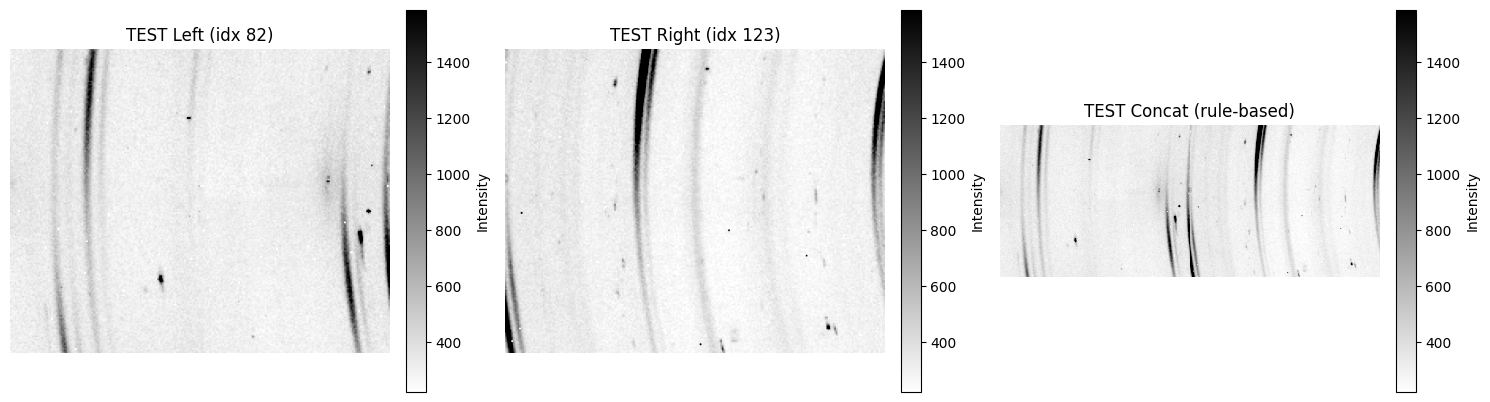

===== VAL =====


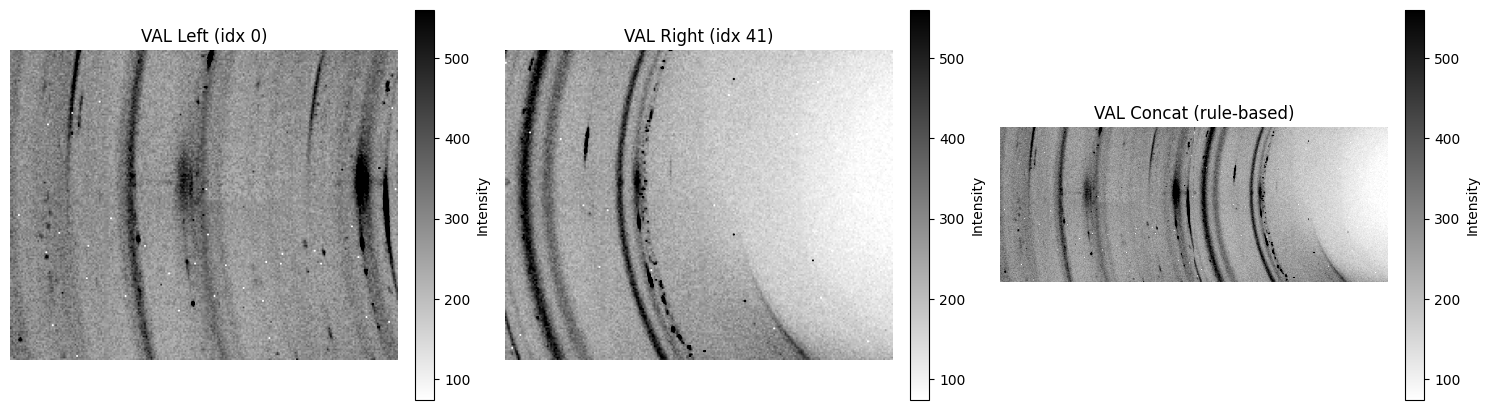

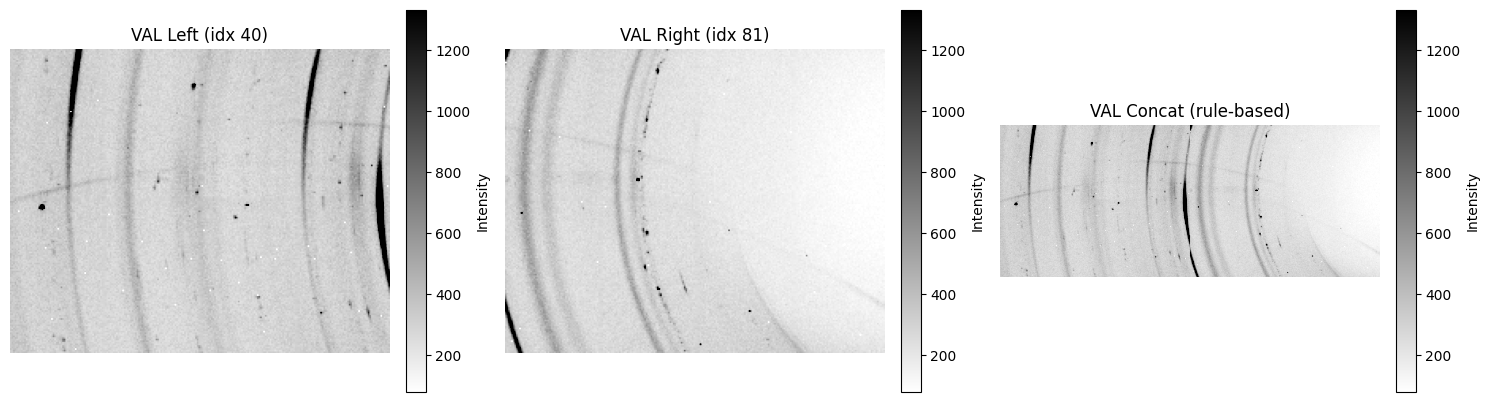

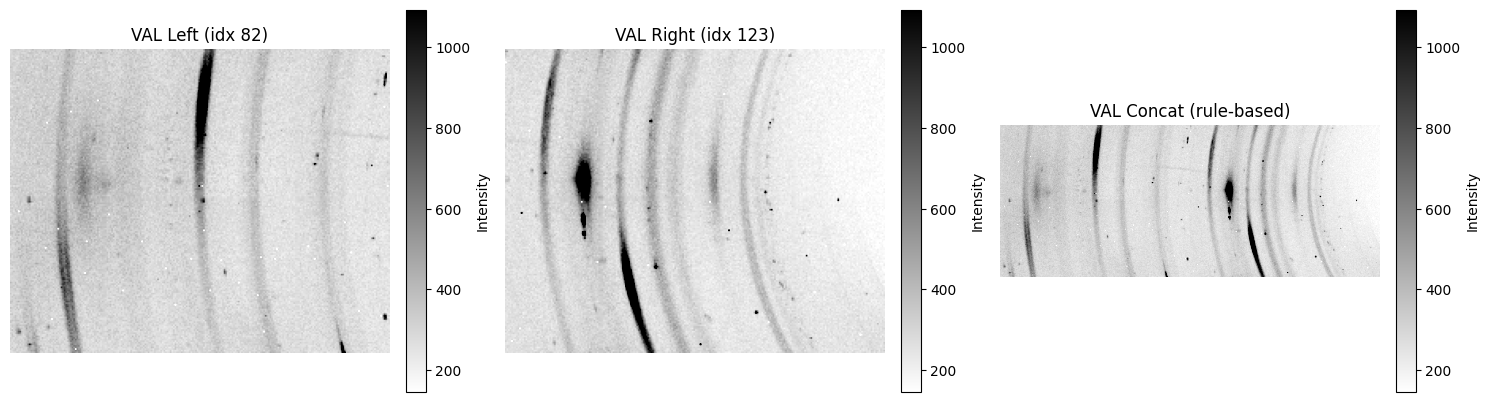

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ===== robuste Skalierung =====
def robust_minmax(img, p_low=1, p_high=99):
    vals = img.ravel()
    vmin, vmax = np.percentile(vals, (p_low, p_high))
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
        vmin, vmax = float(vals.min()), float(vals.max() + 1e-6)
    return vmin, vmax

# ===== feste Block-Paarung =====
HALF = 41
BLOCK = 82

def counterpart_index(idx, N):
    base  = (idx // BLOCK) * BLOCK
    local = idx - base
    if local < HALF:
        j = base + local + HALF
    elif local < 2*HALF:
        j = base + (local - HALF)
    else:
        return None
    return j if 0 <= j < N else None

# ===== Rekonstruktion + optionales Speichern =====
def reconstruct_pairs_by_rule(imgs, indices, split_name="",
                              p_low=1, p_high=99, show=True,
                              left_only=True):

    N = len(imgs)
    shown_keys = set()

    for idx in indices:
        j = counterpart_index(idx, N)
        if j is None:
            print(f"{split_name}: Index {idx} hat keinen gueltigen Gegenpart (Block={BLOCK}).")
            continue

        base  = (idx // BLOCK) * BLOCK
        local = idx - base

        if left_only:
            if local >= HALF:
                k_left = local - HALF
                li = base + k_left
                ri = base + k_left + HALF
            else:
                k_left = local
                li = idx
                ri = j

            key = (base, k_left)
            if key in shown_keys:
                continue
            shown_keys.add(key)
            left_img, right_img = imgs[li], imgs[ri]
        else:
            li, ri = (idx, j) if local < HALF else (j, idx)
            k_left = (li - base)
            key = (base, k_left)
            if key in shown_keys:
                continue
            shown_keys.add(key)
            left_img, right_img = imgs[li], imgs[ri]

        # Concat
        full = np.hstack([left_img, right_img])

        # optional anzeigen
        if show:
            vmins, vmaxs = zip(*(robust_minmax(x, p_low, p_high) for x in (left_img, right_img, full)))
            vmin, vmax = min(vmins), max(vmaxs)

            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            im0 = ax[0].imshow(left_img, cmap="gray_r", origin="lower", vmin=vmin, vmax=vmax)
            ax[0].set_title(f"{split_name} Left (idx {li})");  ax[0].axis("off")
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04).set_label("Intensity")

            im1 = ax[1].imshow(right_img, cmap="gray_r", origin="lower", vmin=vmin, vmax=vmax)
            ax[1].set_title(f"{split_name} Right (idx {ri})"); ax[1].axis("off")
            fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04).set_label("Intensity")

            im2 = ax[2].imshow(full, cmap="gray_r", origin="lower", vmin=vmin, vmax=vmax)
            ax[2].set_title(f"{split_name} Concat (rule-based)"); ax[2].axis("off")
            fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04).set_label("Intensity")

            plt.tight_layout(); plt.show()

# ===== Anwendung =====
indices = [0, 40, 41, 81, 82]
for split in ["train", "test", "val"]:
    high = data[split][0]
    print(f"===== {split.upper()} =====")
    reconstruct_pairs_by_rule(high, indices, split_name=split.upper(),
                          p_low=1, p_high=99,
                          show=True, left_only=True)

